# Adding constraints

We again consider the same problem.
$$
\frac{dy}{dt} = A\sin(\omega t + \delta)
$$

In [1]:
### Dataset
import numpy as np

data = {'Time': np.array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ]), 'y': np.array([0.91963291, 0.99361406, 1.27816619, 1.83477302, 2.0436977 ,
       2.4108738 , 2.84511313, 2.98244074, 3.01343352, 2.81703372,
       2.66941941, 2.31326251, 1.89208529, 1.40799057, 1.2468084 ,
       1.08452949, 1.03682804, 1.22276976, 1.58095538, 1.73274129,
       2.41068701, 2.6162268 , 3.08196062, 3.0313903 , 2.77556916,
       2.75105715, 2.46021415, 1.85709704, 1.60617448, 1.22300332,
       1.03747336, 1.20756063, 1.10867505, 1.42444299, 1.68301796,
       2.09068759, 2.61731029, 2.42544506, 2.97204288, 2.97302454,
       2.98836389, 2.63614576, 2.06298576, 1.73999305, 1.4090971 ,
       1.12819288, 0.92043848, 1.20091581, 1.29993016, 1.38187416])}

## General structure

In [2]:
def sine(y, t, A, omega, delta):
    dy_dt = A * omega * np.sin(omega * t + delta)
    return dy_dt

In [3]:
def simulate_model(params):
    y0 = params['y0']
    A = params['A']
    omega = params['omega']
    delta = params['delta']
    sol = odeint(sine, y0, time, args=(A, omega, delta))
    return sol.flatten()



Next, we define an error function, this error function, depends on the data and the model predicted outcomes. The optimizer minimizes this error function

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import sys
import scipy.io
from concurrent.futures import ProcessPoolExecutor

# Get path 
# Get path to MCMCwithODEs_primer (3 levels up)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..','..','..'))
sys.path.insert(0, project_root)

import sys
sys.path.append('./..')  # or absolute path if needed

from invode import ODEOptimizer, lhs_sample, MSE

## Adding constraint

For an example, let's say we want the value at t = 10, is fixed to 1.5. We can use a constraints.



In [21]:
hyperparam = 0.2
def mse_constrainted(output):
    return np.mean((output - data['y'])**2) + hyperparam*np.abs(output[-1]-1.5)
    

Fitting Progress: 100%|█████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


Refining params: {'A': 1.1915368305751737, 'delta': -0.02444698040884663, 'omega': 1.985154886052043}
Refining params: {'A': 0.9695259615925091, 'delta': 0.29615770908917377, 'omega': 1.9648598743384087}


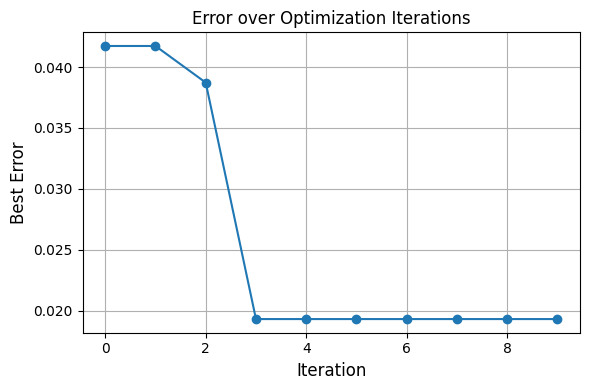

({'A': 1.058478997699118,
  'delta': 0.035691140341976554,
  'omega': 1.9916707918835548,
  'y0': 0.91963291},
 0.013854377444252103)

In [22]:
param_bounds = {
    'y0': 0.91963291, # fixed
    'A': (0.2, 1.5),
    'delta': (-0.5, 0.5),
    'omega': (0.5, 4)
}

time = data['Time']

optimizer_constrained = ODEOptimizer(
    ode_func=simulate_model,
    error_func=mse_constrainted,
    param_bounds=param_bounds,
    seed=42,
    num_top_candidates=2,
    n_samples=300,
    num_iter=10,
    verbose=False,
    verbose_plot=True
)

optimizer_constrained.fit()

The last point is 1.499999984435069


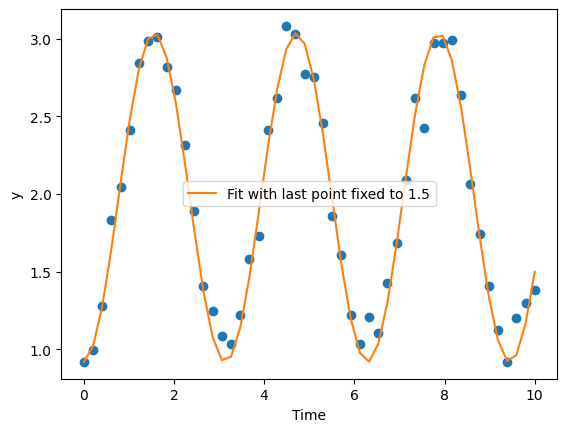

In [26]:
best_params = optimizer_constrained.best_params
best_fit = simulate_model(best_params)



plt.plot(time,data['y'],'o')
plt.plot(time, best_fit, label='Fit with last point fixed to 1.5')
plt.xlabel("Time")
plt.ylabel("y")
plt.legend()

print(f"The last point is {best_fit[-1]}")